In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from modules import *
from utils import *
from training import *

In [3]:
import matplotlib.pyplot as plt

# Dataset

In [4]:
#disable tensorflow from accessing the GPU - it is only processing the dataset
disable_gpu_tf()

In [5]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [6]:
#load the dataset
n_batch = 128
train, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)

In [7]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [8]:
#define a self-attentional model

"""
Self-Attention model

x - input (image, etc.) shape (b x y c)
is_training - true when training model. 
vsa_dimension - VSA/symbol dimensionality to use within the model. 
codebook_sparsity - on (0.0, 1.0), proportion of zero values to force within the class codebook
"""
def self_attention(x, 
                   is_training: bool = False,
                   var_scaling: float = 1.0, 
                   n_priors: int = 32,
                   vsa_dimension: int = 1024,
                   codebook_sparsity: float = 0.75):
    
    #convert int8 [0,255] to float [0.0, 1.0]. 
    x = scale_mnist(x)
    #project each column/channel into VSA (b x y c) -> (b x d)
    x = ProjectRow(vsa_dimension)(x)
    #Compute self-attention over the inputs
    # (b x d) x (b x d) -> (b x d)
    x = SelfAttention(num_heads = 1, widening_factor=1)(x, is_training=is_training)
    # Flatten (x d) for final linear layer
    x = rearrange(x, "b x d -> b (x d)")
    # Merge the priors to produce a single symbol - (b x*d) -> (b d)
    x = conv_1d(vsa_dimension)(x)
    # Compute the similarity between the final symbol and the class codebook
    x = CodebookDecoder(10, vsa_dimension, sparsity=codebook_sparsity)(x)
     
    return x

In [9]:
#declare the model as a transformation
sa_model = hk.transform(self_attention)

In [10]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [11]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = sa_model.init(subkey, x_train[0:10,...])

/home/wolin/anaconda3/envs/jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3729: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "ones")


In [12]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [13]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


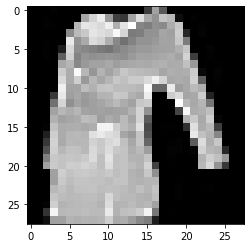

In [14]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

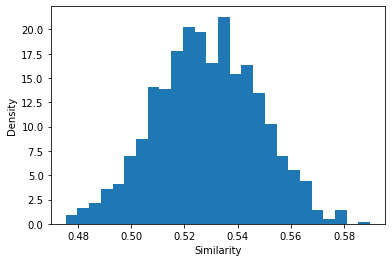

In [15]:
#sample the initial similarities the model produces between an 
# image and the class codebook. When the codebook is sparse,
# most values are centered around zero so initial similarity
# is fairly high.

sim = sa_model.apply(params, key, x, is_training=True)

plt.hist(np.array(sim.ravel()), bins=26, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

Text(0.5, 1.0, 'Pre-Train Similarity')

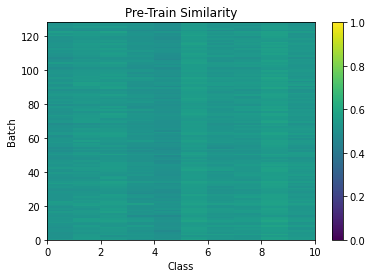

In [16]:
#Visualize the similarity each sample produces to the class codebook
plt.pcolor(sim, vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Pre-Train Similarity")

In [17]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(onehot_loss(sim, y))

DeviceArray(0.47014678, dtype=float32)

# Training

In [18]:
#train the model on the dataset
params_t, losses = train_model(sa_model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = onehot_loss, 
                               batches = 2000)

100%|█████████████████████████████████████████████████| 2000/2000 [05:41<00:00,  5.85it/s]


Text(0, 0.5, 'Loss')

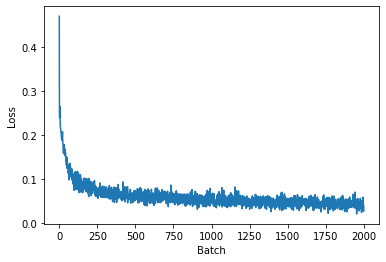

In [19]:
#Plot the history of the loss values over batches
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

In [20]:
np.savez_compressed("sa_fmnist_loss.npz", loss=losses)

In [21]:
ca_losses = np.load("ca_fmnist_loss.npz")['loss']

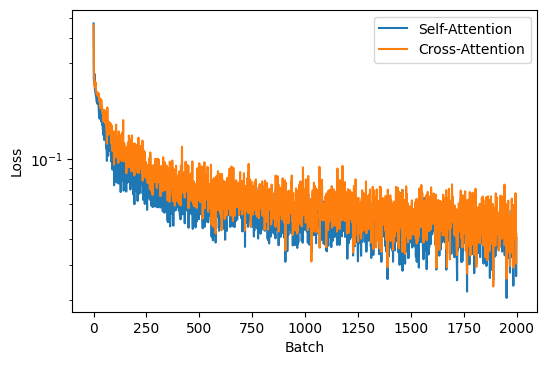

In [24]:
#Plot the history of the loss values over batches
plt.figure(dpi=100)
plt.semilogy(losses, label="Self-Attention")
plt.semilogy(ca_losses, label="Cross-Attention")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

# Test

In [20]:
#Load the testing dataset
test, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)

In [21]:
#Load a non-repeating copy of the training dataset
train2, _, _ = load_dataset(dataset, split="train", is_training=False, repeat = False, batch_size=n_batch)

In [22]:
#define a labmda to compute accuracy we can dispatch over batches
acc_fn = lambda b: accuracy(sa_model, key, params_t, b['image'], b['label'])

In [23]:
#compute the test set accuracy
preds = jnp.concatenate([acc_fn(b) for b in test])
print("Test set accuracy is ", jnp.mean(preds))

Test set accuracy is  0.88619995


In [24]:
#compute train set accuracy
preds_t = jnp.concatenate([acc_fn(b) for b in train2])
print("Train set accuracy is ", jnp.mean(preds_t))

Train set accuracy is  0.91635


Text(0.5, 1.0, 'Post-Train Similarity')

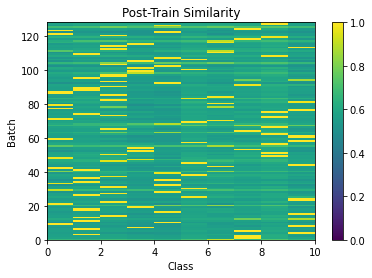

In [25]:
#Visualize the similarity each sample produces to the class codebook
sim2 = sa_model.apply(params_t, key, x)

plt.pcolor(sim2, vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Post-Train Similarity")